In [1]:
"""Notebook to generate some EDA insights"""
# %%
import matplotlib.pyplot as plt
import seaborn as sns

from multitouch_attribution.data.make_dataset import read_dataset

 # TLDR;
 This is a basic EDA step before digging deeper into the modelling workflow. This
 dataset has a lot of potential, since the data shows for example session data as well
 as some customer-specific information like segmentation allocation. <br>
 But since our main goal will be to find an algorithmic attribution based on the given
 channel visits we reduce our analysis to channels, served dates and conversion
 informations. Any additional feature which could improve the model will be left for
 future improvement.

In [2]:
dataset = read_dataset(filename="customer_journey.csv")

dataset.info()

dataset.head()

dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              10037 non-null  object        
 1   date_served          10021 non-null  datetime64[ns]
 2   marketing_channel    10022 non-null  object        
 3   variant              10037 non-null  object        
 4   converted            10022 non-null  object        
 5   language_displayed   10037 non-null  object        
 6   language_preferred   10037 non-null  object        
 7   age_group            10037 non-null  object        
 8   date_subscribed      1856 non-null   datetime64[ns]
 9   date_canceled        577 non-null    datetime64[ns]
 10  subscribing_channel  1856 non-null   object        
 11  is_retained          1856 non-null   object        
dtypes: datetime64[ns](3), object(9)
memory usage: 941.1+ KB


<ipython-input-2-b9905a32f41f>:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  dataset.describe()
<ipython-input-2-b9905a32f41f>:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  dataset.describe()
<ipython-input-2-b9905a32f41f>:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  dataset.describe()


,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
count,10037,10021,10022,10037,10022,10037,10037,10037,1856,577,1856,1856
unique,7309,31,5,2,2,4,4,7,31,115,5,2
top,a100000882,2018-01-15 00:00:00,House Ads,control,False,English,English,19-24 years,2018-01-16 00:00:00,2018-04-02 00:00:00,Instagram,True
freq,12,789,4733,5091,8946,9793,9275,1682,163,15,600,1279
first,NaN,2018-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 00:00:00,2018-01-05 00:00:00,NaN,NaN
last,NaN,2018-01-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-31 00:00:00,2018-05-09 00:00:00,NaN,NaN


 # Basic overview
 ## First insights
 - many columns with missing values $\Rightarrow$ clean data
 - most columns are categoricals with low cardinality $\Rightarrow$ OneHotEncoding
 - few boolean columns $\Rightarrow$ cast to binaries (int)

 # Preprocessing
 ## Restrict dataset to relevant features

In [3]:
dataset = dataset.filter(["user_id", "date_served", "marketing_channel", "converted"])

 ## Handle missing values

In [4]:
# drop all user_ids with missing values in 'converted'
dataset = dataset.dropna(subset=["converted"])

# there is also one user_id with a NaN in 'date_served'
print(dataset.query("date_served != date_served"))
dataset = dataset.query("user_id != 'a100004504'")

# cast boolean column to int
dataset = dataset.astype({"converted": "int"})

         user_id date_served marketing_channel converted
7038  a100004504         NaT         House Ads     False


 ## Look at channel distributions

<AxesSubplot: xlabel='marketing_channel', ylabel='count'>

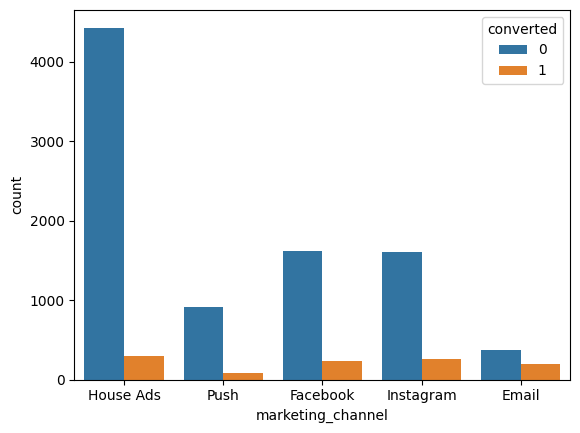

In [5]:
sns.countplot(data=dataset, x="marketing_channel", hue="converted")

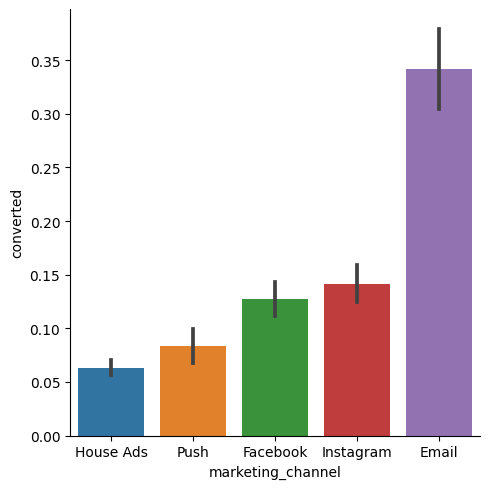

In [6]:
sns.catplot(data=dataset, x="marketing_channel", y="converted", kind="bar")

 ## Take-away: Distribution of conversion
 Looks like * House Ads* is the most used channel, but has just a few conversions
 compared to *Facebook* or *Instagram*. The channel with the most relative
 impact is email. This is a tendency we would like to see in the final attribution
 as well.

 ## Look at channel interaction over time

(array([17532., 17536., 17540., 17544., 17548., 17552., 17556., 17560.,
        17563.]),
 [Text(17532.0, 0, '2018-01-01'),
  Text(17536.0, 0, '2018-01-05'),
  Text(17540.0, 0, '2018-01-09'),
  Text(17544.0, 0, '2018-01-13'),
  Text(17548.0, 0, '2018-01-17'),
  Text(17552.0, 0, '2018-01-21'),
  Text(17556.0, 0, '2018-01-25'),
  Text(17560.0, 0, '2018-01-29'),
  Text(17563.0, 0, '2018-02-01')])

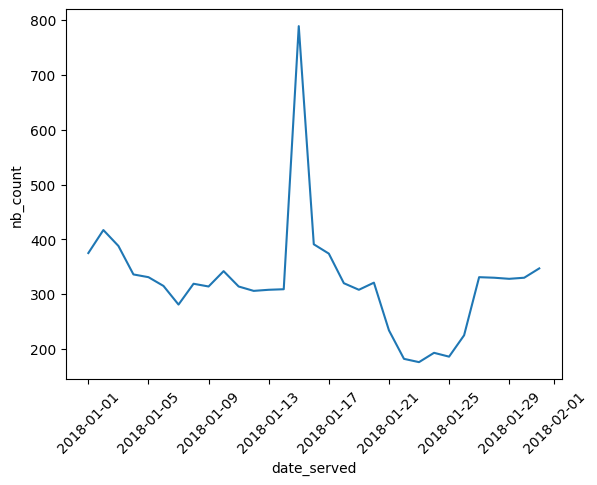

In [7]:
df = dataset.groupby(by=["date_served"]).agg(nb_count=("user_id", "size")).reset_index()
sns.lineplot(data=df, x="date_served", y="nb_count")
plt.xticks(rotation=45)

(array([17532., 17536., 17540., 17544., 17548., 17552., 17556., 17560.,
        17563.]),
 [Text(17532.0, 0, '2018-01-01'),
  Text(17536.0, 0, '2018-01-05'),
  Text(17540.0, 0, '2018-01-09'),
  Text(17544.0, 0, '2018-01-13'),
  Text(17548.0, 0, '2018-01-17'),
  Text(17552.0, 0, '2018-01-21'),
  Text(17556.0, 0, '2018-01-25'),
  Text(17560.0, 0, '2018-01-29'),
  Text(17563.0, 0, '2018-02-01')])

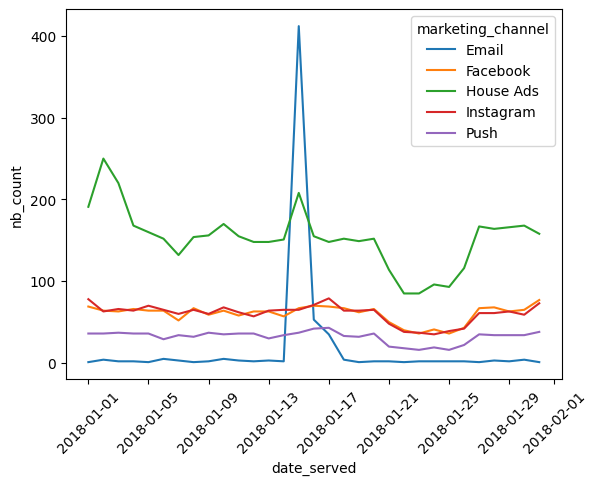

In [8]:
df = (
    dataset.groupby(by=["date_served", "marketing_channel"])
    .agg(nb_count=("user_id", "size"))
    .reset_index()
)

sns.lineplot(data=df, x="date_served", y="nb_count", hue="marketing_channel")
plt.xticks(rotation=45)

 ## Surprising pattern
 It is quite surprising to this pattern for the email channel as a single peak. This
 could be problematic for a ML model if we doesn't provide the served date as a
 feature, but we keep this in mind.